In [2]:
import numpy as np
import pandas as pd;
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import subplots
from ISLP import load_data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from ISLP.models import sklearn_sm
from sklearn.model_selection import \
     (cross_validate,
      KFold,
      ShuffleSplit)

## Exercise 5

In Chapter 4, we used logistic regression to predict the probability of
default using income and balance on the Default data set. We will
now estimate the test error of this logistic regression model using the
validation set approach. Do not forget to set a random seed before
beginning your analysis.
1. Fit a logistic regression model that uses income and balance to
predict default.
2. Using the validation set approach, estimate the test error of this
model. In order to do this, you must perform the following steps:
   1. Split the sample set into a training set and a validation set.
    2. Fit a multiple logistic regression model using only the training
observations.
    3. Obtain a prediction of default status for each individual in
the validation set by computing the posterior probability of
default for that individual, and classifying the individual to
the default category if the posterior probability is greater
than 0.5.
iv. Compute the validation set error, which is the fraction of
the observations in the validation set that are misclassified.
3. Repeat the process in (2) three times, using three different splits
of the observations into a training set and a validation set. Comment
on the results obtained.
4. Now consider a logistic regression model that predicts the probability
of default using income, balance, and a dummy variable
for student. Estimate the test error for this model using the validation
set approach. Comment on whether or not including a
dummy variable for student leads to a reduction in the test error
rate.

### Task 5.1

In [2]:
Default = load_data('Default')
X = Default[['income','balance']]
X = sm.add_constant(X)
Y = Default['default'] == 'Yes'
model = sm.GLM(Y,
             X,
             family=sm.families.Binomial()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                default   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9997
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -789.48
Date:                Thu, 10 Apr 2025   Deviance:                       1579.0
Time:                        17:11:22   Pearson chi2:                 6.95e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1256
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.5405      0.435    -26.544      0.000     -12.393     -10.688
income      2.081e-05   4.99e-06      4.174      0.000     1.1e-05    3.06e-05
balance        0.0056      0.000     24.835      0.000       0.005       0.006
==============================================================================
"""

### Task 5.2

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=1)
model1 = sm.GLM(Y, X, family = sm.families.Binomial()).fit()
Y_test_prob = model1.predict(exog=X_test)
Y_test_lab = Y_test_prob > 0.5
cm = confusion_matrix(Y_test,Y_test_lab)
print('Validation Set Error: ', (cm[1,0]+cm[0,1])/cm.sum())


Validation Set Error:  0.025


### Task 5.3

In [4]:
for i in range(0,10):
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=i)
    model1 = sm.GLM(Y, X, family = sm.families.Binomial()).fit()
    Y_test_prob = model1.predict(exog=X_test)
    Y_test_lab = Y_test_prob > 0.5
    cm = confusion_matrix(Y_test,Y_test_lab)
    print('Validation Set Error: ', (cm[1,0]+cm[0,1])/cm.sum())

Validation Set Error:  0.028
Validation Set Error:  0.025
Validation Set Error:  0.028
Validation Set Error:  0.02
Validation Set Error:  0.0245
Validation Set Error:  0.024
Validation Set Error:  0.0245
Validation Set Error:  0.0265
Validation Set Error:  0.025
Validation Set Error:  0.0185


### Task 5.4

Adding the Student column seems to increase the Validation Set Error

In [5]:
X = Default[['income','balance']].copy()
X['student'] = (Default['student'] == 'Yes').astype(int)
X = sm.add_constant(X)
print(X.head())
for i in range(0,10):
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=i)
    model1 = sm.GLM(Y, X, family = sm.families.Binomial()).fit()
    Y_test_prob = model1.predict(exog=X_test)
    Y_test_lab = Y_test_prob > 0.5
    cm = confusion_matrix(Y_test,Y_test_lab)
    print('Validation Set Error: ', (cm[1,0]+cm[0,1])/cm.sum())

   const        income      balance  student
0    1.0  44361.625074   729.526495        0
1    1.0  12106.134700   817.180407        1
2    1.0  31767.138947  1073.549164        0
3    1.0  35704.493935   529.250605        0
4    1.0  38463.495879   785.655883        0
Validation Set Error:  0.0285
Validation Set Error:  0.026
Validation Set Error:  0.0275
Validation Set Error:  0.02
Validation Set Error:  0.026
Validation Set Error:  0.0255
Validation Set Error:  0.026
Validation Set Error:  0.026
Validation Set Error:  0.024
Validation Set Error:  0.0195


## Exercise 6

We continue to consider the use of a logistic regression model to
predict the probability of default using income and balance on the
Default data set. In particular, we will now compute estimates for the
standard errors of the income and balance logistic regression coefficients
in two different ways: (1) using the bootstrap, and (2) using the
standard formula for computing the standard errors in the sm.GLM()
function. Do not forget to set a random seed before beginning your
analysis.
1. Using the summarize() and sm.GLM() functions, determine the
estimated standard errors for the coefficients associated with
income and balance in a multiple logistic regression model that
uses both predictors.
2. Write a function, boot_fn(), that takes as input the Default data
set as well as an index of the observations, and that outputs
the coefficient estimates for income and balance in the multiple
logistic regression model.
3. Following the bootstrap example in the lab, use your boot_fn()
function to estimate the standard errors of the logistic regression
coefficients for income and balance.
4. Comment on the estimated standard errors obtained using the
sm.GLM() function and using the bootstrap.

### Task 6.1.
see Task 5.1

### Task 6.2 / 6.3

In [6]:
def boot_SE(func,
            D,
            n=None,
            B=1000,
            seed=0):
    rng = np.random.default_rng(seed)
    first_1, second_1, first_2, second_2 = 0, 0, 0, 0
    n = n or D.shape[0]
    for _ in range(B):
        idx = rng.choice(D.index,
                         n,
                         replace=True)
        coeff1, coeff2 = func(D, idx)
        first_1 += coeff1
        second_1 += coeff1**2
        first_2 += coeff2
        second_2 += coeff1**2 
    return np.sqrt(np.maximum(second_1 / B - (first_1 / B)**2,0)), np.sqrt(np.maximum(second_2 / B - (first_2 / B)**2,0))


def boot_fn(data, index):
    X = data[['income','balance']].loc[index]
    Y = data['default'].loc[index] == 'Yes'
    X = sm.add_constant(X)
    model = sm.GLM(Y,
             X,
             family=sm.families.Binomial()).fit()
    return model.params['income'], model.params['balance']

income_coeff_SE, balance_coeff_SE = boot_SE(boot_fn,
                   Default,
                   B=100,
                   seed=0)
print(income_coeff_SE, balance_coeff_SE)


4.685874363883641e-06 0.0


### Task 6.4

The standard errors calculated by bootstraping and those by the Logistic Model itself are very similar

## Exercise 7

In Sections 5.1.2 and 5.1.3, we saw that the cross_validate() function
can be used in order to compute the LOOCV test error estimate.
Alternatively, one could compute those quantities using just sm.GLM()
and the predict() method of the fitted model within a for loop. You
will now take this approach in order to compute the LOOCV error
for a simple logistic regression model on the Weekly data set. Recall
that in the context of classification problems, the LOOCV error is
given in (5.4).
1. Fit a logistic regression model that predicts Direction using Lag1
and Lag2.
2. Fit a logistic regression model that predicts Direction using Lag1
and Lag2 using all but the first observation.
3. Use the model from (2.) to predict the direction of the first observation.
You can do this by predicting that the first observation
will go up if P(Direction = "Up"|Lag1, Lag2) > 0.5. Was this
observation correctly classified?
4. Write a for loop from i = 1 to i = n, where n is the number of
observations in the data set, that performs each of the following
steps:
    1. Fit a logistic regression model using all but the ith observation
to predict Direction using Lag1 and Lag2.
    2. Compute the posterior probability of the market moving up
for the ith observation.
    3. Use the posterior probability for the ith observation in order
to predict whether or not the market moves up.
    4. Determine whether or not an error was made in predicting
the direction for the ith observation. If an error was made,
then indicate this as a 1, and otherwise indicate it as a 0.
5. Take the average of the n numbers obtained in (4.4) in order to
obtain the LOOCV estimate for the test error. Comment on the
results.

## Task 7.1

In [7]:
Weekly = load_data('Weekly')
y = Weekly['Direction'] == 'Up'
X = sm.add_constant(Weekly[['Lag1','Lag2']])
result = sm.GLM(y,X,family=sm.families.Binomial()).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Direction   No. Observations:                 1089
Model:                            GLM   Df Residuals:                     1086
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -744.11
Date:                Thu, 10 Apr 2025   Deviance:                       1488.2
Time:                        17:11:25   Pearson chi2:                 1.09e+03
No. Iterations:                     4   Pseudo R-squ. (CS):           0.007303
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2212      0.061      3.599      0.000       0.101       0.342
Lag1          -0.0387      0.026     -1.477      0.140      -0.090       0.013
Lag2           0.0602      0.027      2.270      0.023       0.008       0.112
==============================================================================
"""

## Task 7.2 / 7.3

In [8]:
y_test = y.iloc[[0]]
y_train = y.iloc[:1]
X_test = X.iloc[[0]]
X_train = X.iloc[:1]
result = sm.GLM(y,X,family=sm.families.Binomial()).fit()
result.summary()
y_test_pred = result.predict(exog=X_test) > 0.5
correct = y_test[0] == (y_test_pred).astype(int)[0]
print('Correctly predicted: ', correct)

Correctly predicted:  False


### Task 7.4 / 7.5

The estimated error rate of 0.44 is realistic as we have seen before that the prediction of market direction is rather uncertain. It is better than random guessing still

In [9]:
correct = 0
for i in range(0,Weekly.shape[0]):
    y_test = y.iloc[[i]]
    y_train = y.drop(index=i)
    X_test = X.iloc[[i]]
    X_train = X.drop(index=i)
    result = sm.GLM(y,X,family=sm.families.Binomial()).fit()
    y_test_pred = result.predict(exog=X_test)
    correct += (y_test == (y_test_pred > 0.5)).astype(int)[i]
CVE = 1 - correct / Weekly.shape[0]
print(CVE)

0.4444444444444444


## Exercise 8

We will now perform cross-validation on a simulated data set.
1. Generate a simulated data set as follows:
```
rng = np.random.default_rng (1)
x = rng.normal(size =100)
y = x - 2 * x**2 + rng.normal(size =100)
```

    In this data set, what is n and what is p? Write out the model
    used to generate the data in equation form.
    
2. Create a scatterplot of X against Y . Comment on what you find.
3. Set a random seed, and then compute the LOOCV errors that
result from fitting the following four models using least squares:
    1. Y = β0 + β1X + ϵ
    2. Y = β0 + β1X + β2X2 + ϵ
    3. Y = β0 + β1X + β2X2 + β3X3 + ϵ
    4. Y = β0 + β1X + β2X2 + β3X3 + β4X4 + ϵ.
    
    Note you may find it helpful to use the data.frame() function
    to create a single data set containing both X and Y .

4. Repeat (3.) using another random seed, and report your results.
Are your results the same as what you got in (3.)? Why?
5. Which of the models in (3.) had the smallest LOOCV error? Is
this what you expected? Explain your answer.
6. Comment on the statistical significance of the coefficient estimates
that results from fitting each of the models in (3.) using
least squares. Do these results agree with the conclusions drawn
based on the cross-validation results?

#### Task 8.1

$$
y = x - 2x^2 + \epsilon
$$

with n=100 and p=0


In [10]:
n=100
rng = np.random.default_rng(10)
x = rng.normal(size =n)
y = x - 2 * x**2 + rng.normal(size =n)

#### Task 8.2

From the scatterplot, one can tell that the relationship is non-linear (quadratic) as expected.

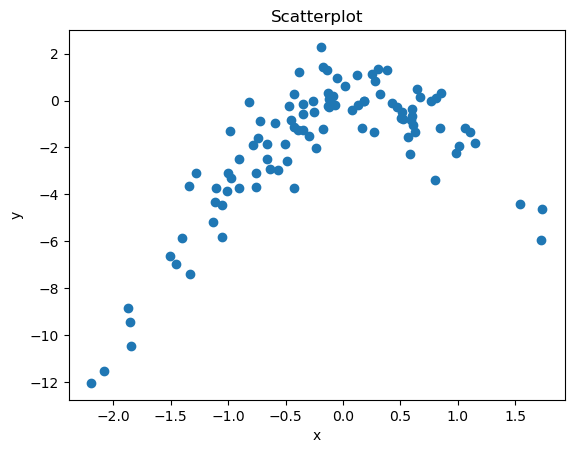

In [11]:
plt.scatter(x,y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatterplot')
plt.show()

#### Task 8.3.
As expected the lowest MSE (1.12) is when we fit ii. Y = β0 + β1X + β2X2 + ϵ. The high MSE for the first model (6.63) results from high bias of fitting a linear model to an underlying nonlinear dataset. And on the other hand, models three (1.3) and four(1.33) to overfit, meaning they have to high a variance

#### Task 8.3.1

In [12]:
data = pd.DataFrame({
    'X': x,
    'X**2': x**2,
    'X**3': x**3,
    'X**4': x**4,
    'Y': y
})

mse = 0
for i in range(0,n):
    y = data['Y']
    X = sm.add_constant(data['X']) 
    y_test = y.iloc[[i]]
    y_train = y.drop(index=i)
    X_test = X.iloc[[i]]
    X_train = X.drop(index=i)
    result = sm.OLS(y_train,X_train).fit()
    y_test_pred = result.predict(exog=X_test)
    mse += (y_test[i] - y_test_pred[i])**2
CVE = mse/n
print(CVE)

5.671283893130448


#### Task 8.3.2

In [13]:
mse = 0
for i in range(0,n):
    y = data['Y']
    X = sm.add_constant(data[['X','X**2']]) 
    y_test = y.iloc[[i]]
    y_train = y.drop(index=i)
    X_test = X.iloc[[i]]
    X_train = X.drop(index=i)
    result = sm.OLS(y_train,X_train).fit()
    y_test_pred = result.predict(exog=X_test)
    mse += (y_test[i] - y_test_pred[i])**2
CVE = mse/n
print(CVE)

1.1594262155692305


#### Task 8.3.3

In [14]:
mse = 0
for i in range(0,n):
    y = data['Y']
    X = sm.add_constant(data[['X','X**2','X**3']]) 
    y_test = y.iloc[[i]]
    y_train = y.drop(index=i)
    X_test = X.iloc[[i]]
    X_train = X.drop(index=i)
    result = sm.OLS(y_train,X_train).fit()
    y_test_pred = result.predict(exog=X_test)
    mse += (y_test[i] - y_test_pred[i])**2
CVE = mse/n
print(CVE)

1.172064007941837


#### Task 8.3.4

In [15]:
mse = 0
for i in range(0,n):
    y = data['Y']
    X = sm.add_constant(data[['X','X**2','X**3','X**4']]) 
    y_test = y.iloc[[i]]
    y_train = y.drop(index=i)
    X_test = X.iloc[[i]]
    X_train = X.drop(index=i)
    result = sm.OLS(y_train,X_train).fit()
    y_test_pred = result.predict(exog=X_test)
    mse += (y_test[i] - y_test_pred[i])**2
CVE = mse/n
print(CVE)

1.1726486579598627


#### Task 8.4
When I use different seeds the overfitting does not happen anymore. The different results stem from different simulated datasets.
- the linear model is still greatly suffering from bias (=14.6), but now the cubic has the lowest estimated error and even the quartic is still lower than the quadratic.

=> but I realize is slightly misunderstood the task, as I am supposed to use the function cross_validation() from scikit-learn. And the helper function sklearn_sm from islp. The random-seeding is not supposed to be applied to the data simulation, but to the cross_validation - meaning the fold selection. Which of course would not have an impact here, as with LOOCV it does not matter in which order we apply it. I will present here the version with those two functions.

The results from using cross_validate() are exactly the same as my handwritten LOOCV. 

In [16]:
cve = np.zeros(4)
M = sklearn_sm(sm.OLS)
for i in range(1,5):
    X = np.power.outer(x,np.arange(i+1))
    M_CV = cross_validate(M, X,y,cv=len(x))
    cve[i-1] = np.mean(M_CV['test_score'])
print(cve)

[5.67128389 1.15942622 1.17206401 1.17264866]


#### Task 8.5

I would have expected the results we achieved when we seeded the simulated data as suggested in the task ( np.randomdefulat_rng(1)) - where the lowest test error was with the linear model. Having found out by chance that this is not always the case, but that often times the cubic model has the lowest test error, makes me think that we should try this with a higher n and with even higher polynomials. Since with more observations overfitting should become less likely. 

8.5* shows that up to 400 observations the average degree of best fit polynomial model does decrease, but above that there seem to always be some high degrees of best fit creeping in here and there, so that the average does not go down further. Also drawing a few of the fitter higher degree models explains why sometimes highed degree models fit better: We use a normal distribution for x. That means the noise on the edges of the x Intervall is more impactful in making the underlying pattern appear non-symmetric sometimes which is why sometimes higher degree polynomials appear a better fit. The potential high variance of a polynomial model is not captured within the x-interval but is only used to capture minimal non-symmetric curve lines on the edges. Therefore a uniform distribution of x should give a clearer preference for quadratic models.

Redoing 8.5* with a uniform distribution shows: I was wrong again. Here it also converges towars an average best degree fit at about 2.7. I am not sure how to interpret this 

Seed:  1
Seed:  2
Seed:  3
Seed:  4
Seed:  5
Seed:  6
Average best fitting degree: 2.9166666666666665


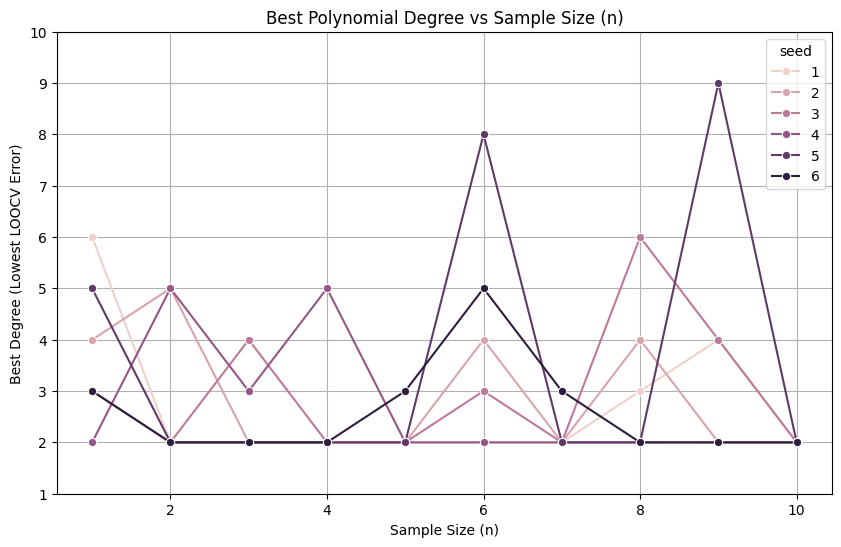

In [15]:
results = []
for s in range(1,7):
    print('Seed: ',s)
    for i in range(1,11):
        n=100*i
        rng = np.random.default_rng(s)
        x = rng.normal(size =n)
        y = x - 2 * x**2 + rng.normal(size =n)

        cve = np.zeros(10)
        M = sklearn_sm(sm.OLS)
        for j in range(1,11):
            X = np.power.outer(x,np.arange(j+1))
            M_CV = cross_validate(M, X,y,cv=len(x))
            cve[j-1] = np.mean(M_CV['test_score'])
        results.append((s,i,(np.argmin(cve) +1)))
df = pd.DataFrame(results, columns=['seed', 'n', 'best_degree'])
print(f"Average best fitting degree: {np.mean(df['best_degree'])}")
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='n', y='best_degree', hue='seed', marker='o')
plt.title("Best Polynomial Degree vs Sample Size (n)")
plt.xlabel("Sample Size (n)")
plt.ylabel("Best Degree (Lowest LOOCV Error)")
plt.yticks(range(1, 11))
plt.grid(True)
plt.show()

#### Task 8.5*
I want to redo this piece of code using the magical formula 5.2 to calculate the CVE and check whether the results are the same. And they are!

[       nan 2.5        2.5        2.55555556 3.         2.93333333
 2.83333333 2.76190476 2.6875     2.7037037  2.71666667 2.86363636
 2.79166667 2.85897436 2.8452381  2.78888889 2.73958333 2.69607843
 2.82407407 2.85964912 2.83333333 2.85714286 2.81818182 2.80434783
 2.8125     2.78       2.76282051 2.74074074 2.72619048 2.75862069
 2.74444444 2.72580645 2.70833333 2.73737374 2.74509804 2.72380952
 2.7037037  2.70720721 2.74122807 2.73504274]


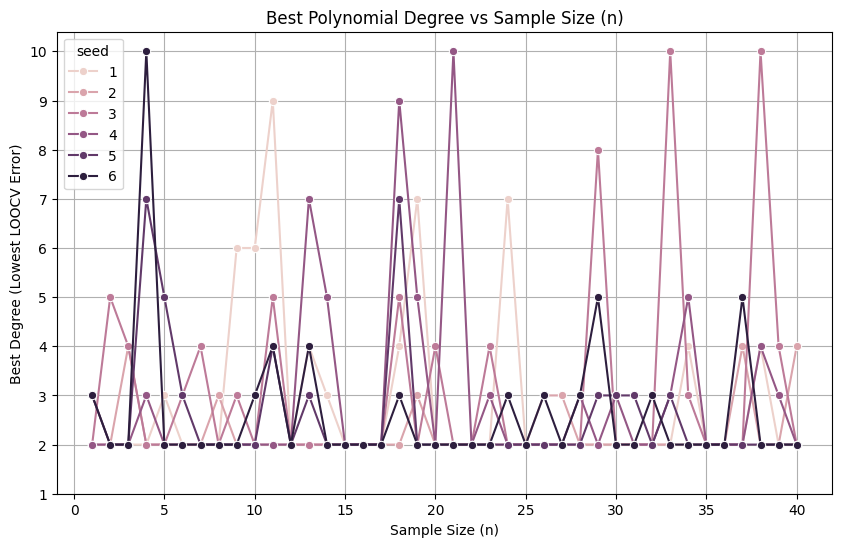

In [2]:
results = []
seed_number= 6
observation_number = 40
degree_number = 10
for s in range(1,seed_number + 1):

    for i in range(1,observation_number +1):
        n=100*i

        rng = np.random.default_rng(s)
        x = rng.uniform(-3,3,n)
        y = x - 2 * x**2 + rng.normal(size =n)
        
        cve = np.zeros(degree_number)
        for j in range(1,degree_number + 1):
            X = np.power.outer(x,np.arange(j+1))
            model = sm.OLS(y, X).fit()
    
        # Get predictions and hat matrix
            y_hat = model.fittedvalues
            hat_matrix = X @ np.linalg.inv(X.T @ X) @ X.T
            h = np.diag(hat_matrix)
    
        # LOOCV error using the shortcut formula
            loocv_error = np.mean(((y - y_hat) / (1 - h))**2)
            cve[j-1] = loocv_error
        results.append((s,i,(np.argmin(cve) +1)))
df = pd.DataFrame(results, columns=['seed', 'n', 'best_degree'])
av_best_degree = np.zeros(observation_number)
for i in range(1,observation_number+1):
    filtered_df = df[df['n'] < i]
# Calculate the mean of the 'best_degree' column for the filtered rows
    av_best_degree[i-1] = filtered_df['best_degree'].mean()
print(av_best_degree)
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='n', y='best_degree', hue='seed', marker='o')
plt.title("Best Polynomial Degree vs Sample Size (n)")
plt.xlabel("Sample Size (n)")
plt.ylabel("Best Degree (Lowest LOOCV Error)")
plt.yticks(range(1, degree_number + 1))
plt.grid(True)
plt.show()

N =  900


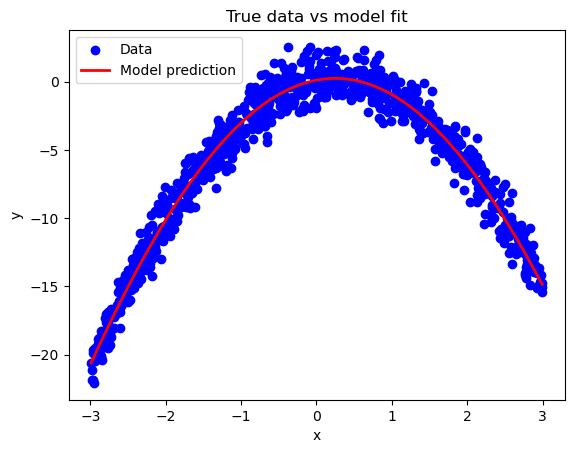

N =  600


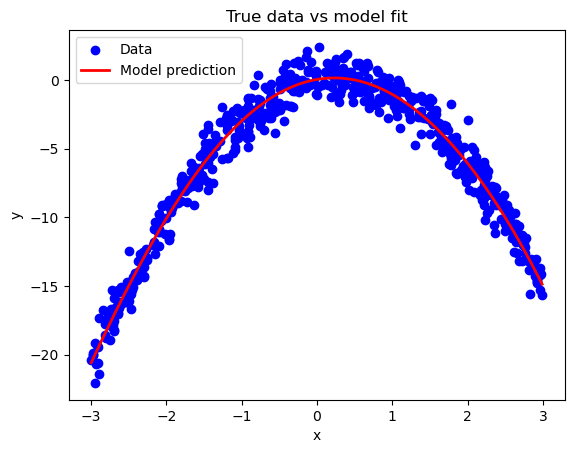

N =  900


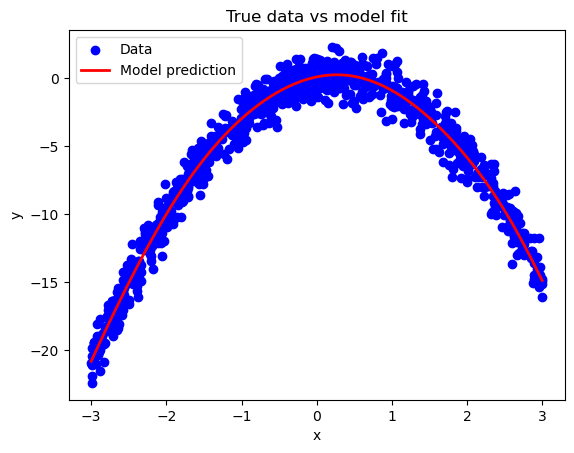

N =  200


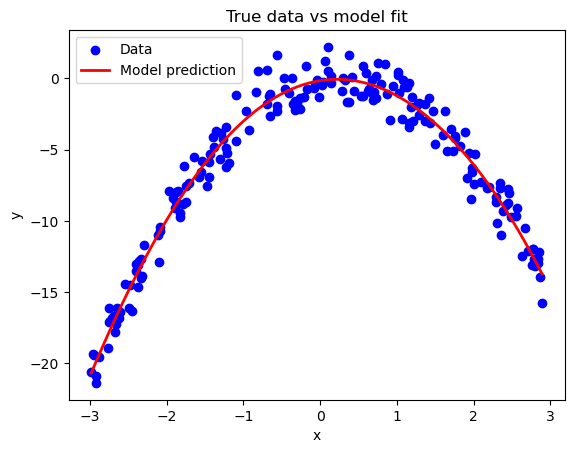

N =  800


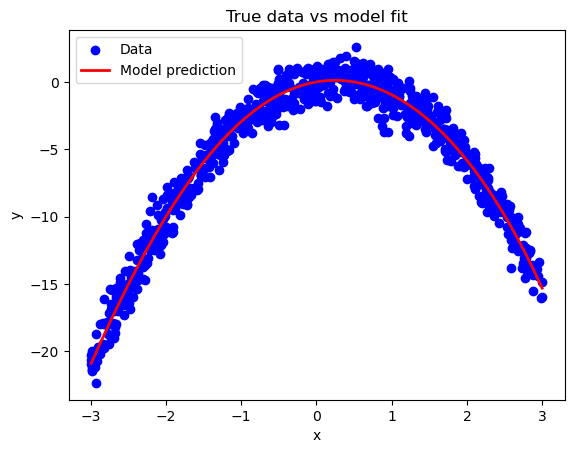

In [62]:
def scatter_graph(x,y,model,degree):
    # 1. Your data (already created)
    plt.scatter(x, y, label='Data', color='blue')
    
    # 2. Create a smooth set of x-values for plotting the predicted function
    x_line = np.linspace(min(x), max(x), 500)

    x_line_ = np.power.outer(x_line,np.arange(degree+1))
    
    # 3. Predict using your model
    # If you're using np.polyfit / np.poly1d
    y_pred = model.predict(x_line_)
    
    # 4. Plot the model as a line
    plt.plot(x_line, y_pred, label='Model prediction', color='red', linewidth=2)
    
    # 5. Labels and legend
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('True data vs model fit')
    plt.legend()
    plt.show()

feed = [[900,1,4],[600,6,5],[900,5,9],[200,2,5], [800,3,6]]
for [n,s,j] in feed:
    print('N = ',n)
    rng = np.random.default_rng(s)
    x = rng.normal(size =n)
    y = x - 2 * x**2 + rng.normal(size =n)
    
    M = sklearn_sm(sm.OLS)
    X = np.power.outer(x,np.arange(j+1))
    model = sm.OLS(y,X).fit()
    scatter_graph(x,y,model,j)

#### Task 8.6

IN the linear model the intercept still holds statistical significance. But from the quadratic model onwards only the linear and quadratic coefficient have statistical significance, which is to be expectected as the underlying data generating model ist quadratic without an intercept

In [5]:
results = []
seed_number= 1
observation_number = 1
degree_number = 4
for s in range(1,seed_number + 1):

    for i in range(1,observation_number +1):
        n=100*i

        rng = np.random.default_rng(s)
        x = rng.uniform(-3,3,n)
        y = x - 2 * x**2 + rng.normal(size =n)
        
        cve = np.zeros(degree_number)
        for j in range(1,degree_number + 1):
            X = np.power.outer(x,np.arange(j+1))
            model = sm.OLS(y, X).fit()
    
            print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     10.97
Date:                Wed, 16 Apr 2025   Prob (F-statistic):            0.00130
Time:                        13:15:36   Log-Likelihood:                -307.49
No. Observations:                 100   AIC:                             619.0
Df Residuals:                      98   BIC:                             624.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.0057      0.530    -11.339      0.0

## Exercise 9

We will now consider the Boston housing data set, from the ISLP
library.
1. Based on this data set, provide an estimate for the population
mean of medv. Call this estimate µ̂.
2. Provide an estimate of the standard error of µ̂. Interpret this
result.
Hint: We can compute the standard error of the sample mean by
dividing the sample standard deviation by the square root of the
number of observations.
3.  Now estimate the standard error of µ̂ using the bootstrap. How
does this compare to your answer from (b)?
4.  Based on your bootstrap estimate from (c), provide a 95 % con-
fidence interval for the mean of medv. Compare it to the results
obtained by using Boston['medv'].std() and the two standard
error rule (3.9).
Hint: You can approximate a 95 % confidence interval using the
formula [µ̂ − 2SE(µ̂), µ̂ + 2SE(µ̂)].
5. Based on this data set, provide an estimate, µ̂med , for the median
value of medv in the population.
6. We now would like to estimate the standard error of µ̂med . Unfor-
tunately, there is no simple formula for computing the standard
error of the median. Instead, estimate the standard error of the
median using the bootstrap. Comment on your findings.
7. Based on this data set, provide an estimate for the tenth per-
centile of medv in Boston census tracts. Call this quantity µ̂0.1 .
(You can use the np.percentile() function.)
np.
8. Use the bootstrap to estimate the standard error of µ̂0.1 . Com- percentile()
ment on your findings.

#### Task 9.1

In [23]:
Boston = load_data('Boston')
mean = np.mean(Boston['medv'])
print(mean)

22.532806324110677


#### Task 9.2

If you took many samples of the same size as the Boston dataset, and calculated the sample mean of 'med' each time, those sample means would, on average, deviate by about 0.4 from the true population mean.

In [12]:
n = len(Boston)
x = Boston['medv']
sd = np.sqrt(1/(n-1) * np.sum((x-mean)**2))
se_mean = sd/np.sqrt(n)
print(se_mean)

0.40886114749753505


#### Task 9.3

The empirical bootstrap method results (0.41253476750888246) in a value close to the analytical estimation (0.40886114749753505) , so I would I consider this validated. 

In [30]:
def boot_SE(func,
            D,
            n=None,
            B=1000,
            seed=3):
    rng = np.random.default_rng(seed)
    first_1, second_1 = 0, 0
    n = n or D.shape[0]
    for _ in range(B):
        idx = rng.choice(D.index,
                         n,
                         replace=True)
        param = func(D, idx)
        first_1 += param
        second_1 += param**2
    return np.sqrt(np.maximum(second_1 / B - (first_1 / B)**2,0))

def boot_fn(data, index):
    X = data['medv'].loc[index]
    return np.mean(X)

mean_SE = boot_SE(boot_fn,
                   Boston,
                   B=1000,
                   seed=2)
print(mean_SE)

0.39529987254264903


#### Task 9.4



In [27]:
print(f"Confidence Interval based on Bootstrap from {mean - 2*mean_SE} to { mean + 2*mean_SE}")
mean_SE_2 = Boston['medv'].std()/np.sqrt(n)
print(f"Confidence Interval based on Analytical results from {mean - 2*mean_SE_2} to { mean + 2*mean_SE_2}")

Confidence Interval based on Bootstrap from 21.71059399457195 to 23.355018653649402
Confidence Interval based on Analytical results from 21.951130388235388 to 23.114482259985966


#### Task 9.5


In [28]:
median = np.median(Boston['medv'])
print(median)

21.2


#### Task 9.6

The standard errror of 0.369 indicates that if we repeatedly sample from the population of the size of the Boston data, the resulting sample median will on average deviate 0.369 from the true median.

In [29]:
def boot_fn_2(data, index):
    X = data['medv'].loc[index]
    return np.median(X)

median_SE = boot_SE(boot_fn_2,
                   Boston,
                   B=1000,
                   seed=0)
print(median_SE)

0.36944622071302163


#### Task 9.7 / 9.8

The standard error is 0.5

In [31]:
percentile = np.percentile(Boston['medv'], 10)
print(percentile)

12.75


In [33]:
def boot_fn_3(data, index):
    X = data['medv'].loc[index]
    return np.percentile(X, 10)

percentile_SE = boot_SE(boot_fn_3,
                   Boston,
                   B=1000,
                   seed=0)
print(percentile_SE)

0.5034541091295026
